### Author: Sabin Adhikari

# Capstone project - Santander Value Prediction Challenge

## Overview:

  Recognizing that customers are more likely to do business with their banks if the banks provide personalized service, Santander Group is asking to help them identify the values of transactions for each potential customer. The problem here is to predict customer's future transction value by using their past transction values.   

### Method:
After performing some data cleaning and exploratory data analysis, we started modeling from simple multilinear regression, ridge, lasso and univariate feature selection. After that, we used LightGBM and XGB to make a regression model and stacked them. We systematically followed the steps listed below.
 #### 1. Preparation of data
 #### 2. Exploratory data analysis
 #### 3. Modeling
   (a) Simple multilinear regression, Ridge and Lasso
   (b) LightGBM
   (c) XGB
 #### 4. Submission to Kaggle
 #### 5. Discussion

## 1. Preparation of data

In [1]:
# Import the data
import pandas as pd
df_train = pd.read_csv('train.csv', index_col = 'ID') # train data
df_test = pd.read_csv('test.csv', index_col = 'ID') # test data

# check for missing values
df_train.isnull().values.any() # gives 'False' - meaning there is no missing value
df_test.isnull().values.any() # gives 'False' 

# check and remove constant columns
cols_to_remove = []
for col in df_train.columns:
    if df_train[col].std() == 0: 
        cols_to_remove.append(col)

# remove constant columns in the train and test sets
df_train.drop(cols_to_remove, axis=1, inplace=True)  
df_test.drop(cols_to_remove, axis=1, inplace=True)
#print(df_test.shape)
#print(df_train.shape)
# remove duplicate columns
df1 = df_train.T.drop_duplicates().T
#print(df1.shape)
print(df_test.shape)

(49342, 4735)


The data provided has train and test sets. The train data has 4991 feature columns, one target column and 4459 rows. 
The test data has 4991 feature columns and 49342 rows. Some constant columns were found in both test and train data sets, and were removed. We found a few columns which were constant in train but not in the test. We ignored these columns from the test while modeling. 


## 2. Exploratory data analysis
Since there are 4735 features (after removing the constant features), we start by looking at the most important features. GradientBoostingRegressor is used to choose the important features.

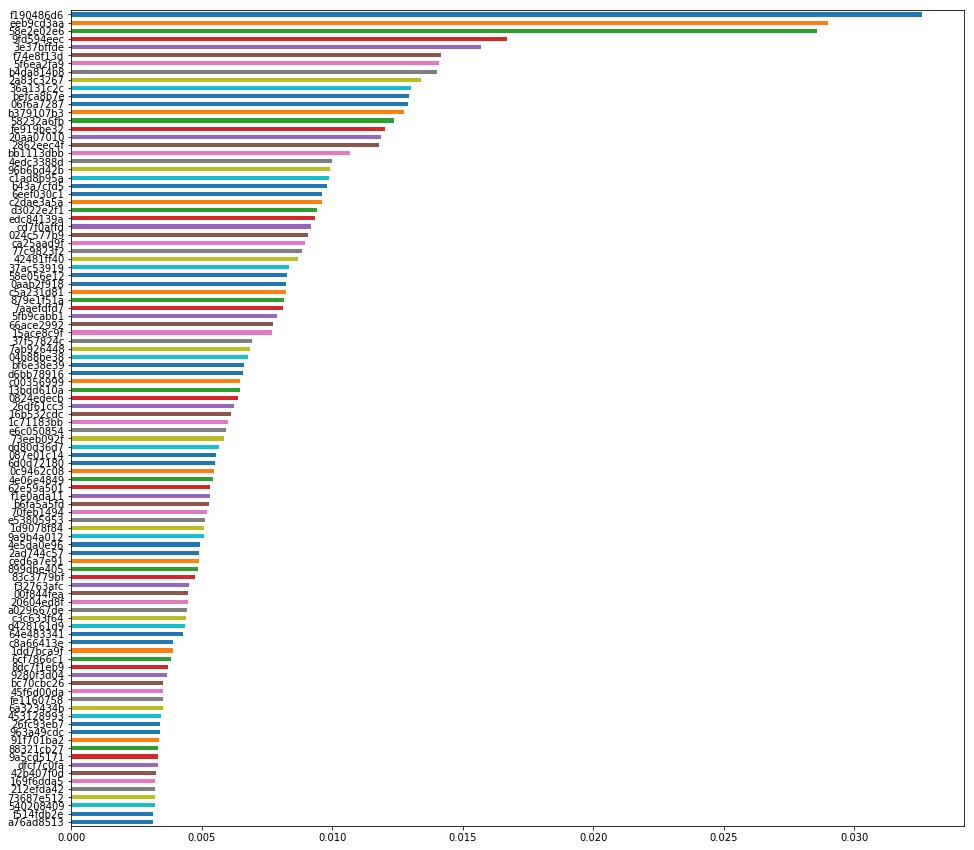

In [2]:
# feature selection by gradientboost

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
X = df1.drop('target',axis = 1)
y = df1['target']
gb = GradientBoostingRegressor(random_state = 42)
gb.fit(X, y)

feat_importances = pd.Series(gb.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(100)
imp_features = feat_importances.index.values
plt.figure(figsize=(16,15))
feat_importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()
#plt.savefig(feature_imp.png)
#print(y)

It shows from the plot above that there a few very important features and the feature importance quickly drops down to an order of magnitude less after 100 most important features. Now we look at how a few most important features are correlated to each other.



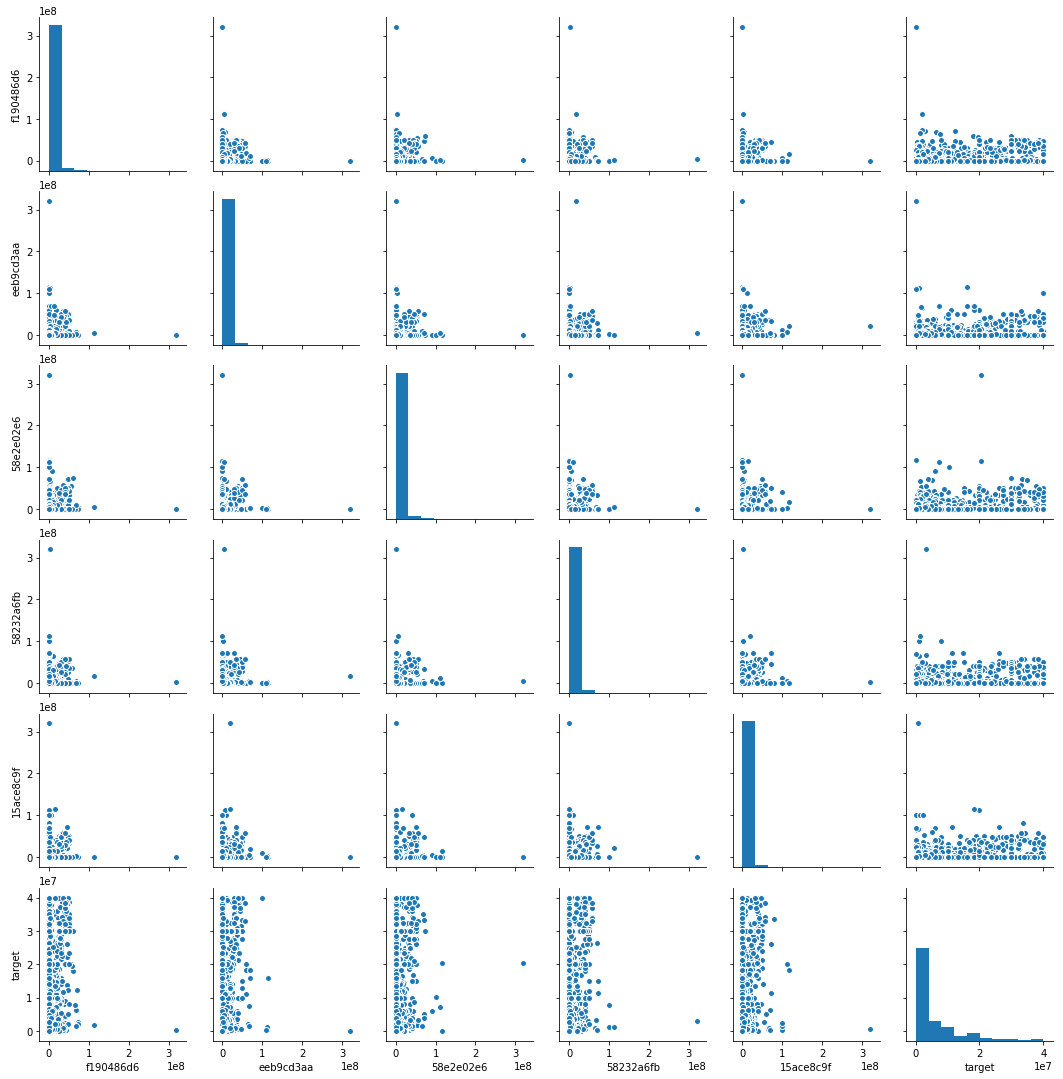

In [3]:
# Look for feature correlation
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
df_plot = X[['f190486d6', 'eeb9cd3aa', '58e2e02e6', '58232a6fb', '15ace8c9f']]
df_plot['target'] = y
sns.pairplot(df_plot)

The pairplot above shows the scatter plots for features-features, features-target and the histograms for features and the target. One interesting observation here is that, all of the 5 most important features have very less spread (shown by the histograms) compared to the target.

## 3. Modeling
### a) Simple multilinear regression, ridge and lasso

In [4]:
#Simple multilinear regression
#%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
reg_all = linear_model.LinearRegression()
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)
print(reg_all.score(X_test, y_test))

-354558119056.3112


Very high value of $R^{2}$, which is as expected because of large number of features.

C:\Users\sabin\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


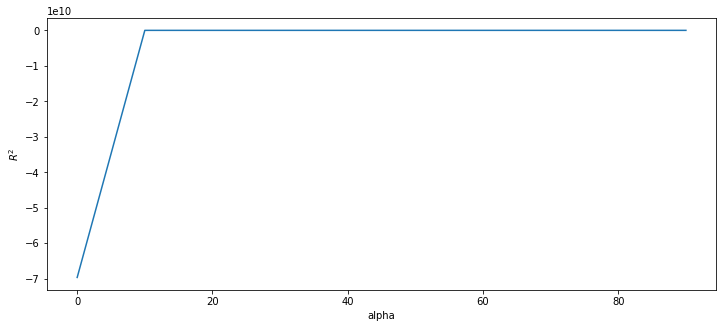

[-69625928567.66788, -1866.832791294166, -571.790018432965, -279.4076980785389, -166.9024062731248, -111.55452825021466, -80.11759931458172, -60.48656232049772, -47.37388532745582, -38.16290851075793]


In [5]:
## Ridge Regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
score_list = []
parameter_list = list(np.arange(0,100,10))
for a in parameter_list:
    ridge = Ridge(alpha = a, normalize = True)
    ridge.fit(X_train, y_train)
    score_list.append(ridge.score(X_test, y_test))
plt.figure(figsize=(12, 5))
plt.plot(parameter_list, score_list)
plt.xlabel('alpha')
plt.ylabel('$R^2$')
plt.savefig('ridge_alpha vs R sq')
plt.show()
print(score_list)
#print(y)

Magnitude of $R^{2}$ decreases with alpha but small values of $R^{2}$ are obtained for very high values of alpha.

In [6]:
# Lasso regression
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=-10)
lasso.fit(X_train, y_train)
print(lasso.score(X_test,y_test))


-174020.59119553686


C:\Users\sabin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [7]:
#print(y.values)
y = np.log(1+y.values)# rescaling of target
                       #https://www.kaggle.com/tunguz
#print(y)
print(y)

[17.45309674 13.3046866  16.11809575 ... 14.84513033 16.11809575
 16.81124288]


Very high $R^{2}$ values are obtained for simple multilinear, ridge and lasso regression. Now we try light GB and XG boost models.

## b) LightGBM

In [8]:

import numpy as np
#print(y.values)
# Start modeling by using LightGBM
import numpy as np
import lightgbm as lgb
from sklearn.grid_search import GridSearchCV
train = lgb.Dataset(X, y, feature_name = "auto")

params = {'boosting_type': ['gbdt'], 
          'objective': ['regression'], 
          'metric': ['rmse'], 
          'learning_rate': [0.01,0.02,0.05], 
          'num_leaves': [50,100], 
          'feature_fraction': [0.4], 
          'bagging_fraction': [0.6], 
          'max_depth': [5], 
          'min_child_weight': [6,7]}

gbm = lgb.LGBMRegressor()

gbm_grid = GridSearchCV(gbm,
                        params,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

gbm_grid.fit(X, y)
print(gbm_grid.grid_scores_, gbm_grid.best_params_, gbm_grid.best_score_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=5)]: Done  24 out of  24 | elapsed:   49.4s finished


[mean: 0.17059, std: 0.00511, params: {'bagging_fraction': 0.6, 'boosting_type': 'gbdt', 'feature_fraction': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 6, 'num_leaves': 50, 'objective': 'regression'}, mean: 0.17059, std: 0.00511, params: {'bagging_fraction': 0.6, 'boosting_type': 'gbdt', 'feature_fraction': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 6, 'num_leaves': 100, 'objective': 'regression'}, mean: 0.17059, std: 0.00511, params: {'bagging_fraction': 0.6, 'boosting_type': 'gbdt', 'feature_fraction': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 7, 'num_leaves': 50, 'objective': 'regression'}, mean: 0.17059, std: 0.00511, params: {'bagging_fraction': 0.6, 'boosting_type': 'gbdt', 'feature_fraction': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 7, 'num_leaves': 100, 'objective': 'regression'}, mean: 0.23292, std: 0.00572, params: {'ba

49342


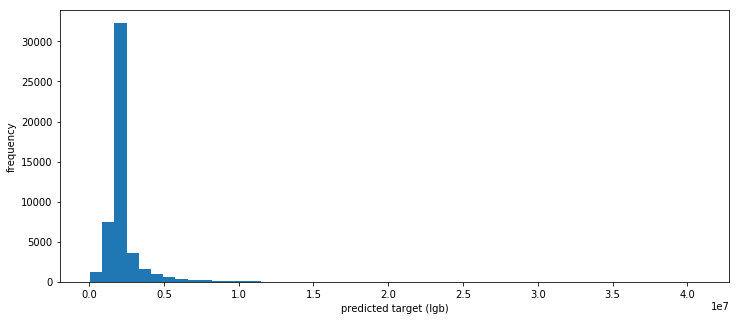

In [12]:
## predict target values
predicted_target = gbm_grid.predict(df_test[X.columns.values])
predicted_target_lgb = np.exp(predicted_target)-1 # predicted target

#plot a histogram of predicted targets
plt.figure(figsize=(12, 5))
num_bins = 50
plt.hist(predicted_target_lgb, num_bins)
plt.xlabel('predicted target (lgb)')
plt.ylabel('frequency')
plt.savefig('predicted target (lgb)')
print(len(predicted_target))

In [13]:
print(predicted_target_lgb)

[1871947.96426679 1819688.93156978 1645345.91576764 ... 1143014.90749489
 1075066.56262995 1819688.93156978]


In [14]:
df_predict = pd.DataFrame({'ID': df_test.index.values,'target': predicted_target_lgb})
print(df_predict.head(10))
export_csv = df_predict.to_csv (r'C:\Users\sabin\Desktop\DataScience\Santander_value_prediction_challenge\prediction_table_lgb.csv', index = None, header=True)

          ID        target
0  000137c73  1.871948e+06
1  00021489f  1.819689e+06
2  0004d7953  1.645346e+06
3  00056a333  3.269272e+06
4  00056d8eb  1.819689e+06
5  0005fc190  1.761077e+06
6  000787e86  1.819689e+06
7  0008510a0  1.838319e+06
8  000895faf  1.819689e+06
9  000986fba  2.450642e+06


## c) XGB with grid search CV


In [ ]:
# xgb cross-validation with greadsearch
y = df1['target']
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

params = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [0.01, 0.02], 
              'max_depth': [5,6,7],
              'min_child_weight': [5,7],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [800]}

xgb1 = XGBRegressor()
xgb_grid = GridSearchCV(xgb1,
                        params,
                        cv = 4,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X, y)

#print(xgb_grid_score_)
print(xgb_grid.best_params_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


In [ ]:
predicted_target_xgb=xgb_grid.predict(df_test[X.columns.values]) # predict target values

In [ ]:
# plot a histogram of predicted targets
plt.figure(figsize=(12, 5))
num_bins = 50
plt.hist(predicted_target_xgb, num_bins)
plt.xlabel('predicted target (xgb)')
plt.ylabel('frequency')
#print(len(predicted_target_xgb))

# 4. Ensembling the two models and submitting the final prediction

In [19]:
alpha_lgb = 0.4
alpha_xgb = 0.6
predicted_target = (alpha_lgb*np.array(predicted_target_lgb)+alpha_xgb*np.array(predicted_target_xgb))/1
#print(predicted_target[:10])
df_predict = pd.DataFrame({'ID': df_test.index.values,'target': predicted_target})
#print(df_predict.head(10))
export_csv = df_predict.to_csv (r'C:\Users\sabin\Desktop\DataScience\Santander_value_prediction_challenge\prediction_table.csv', index = None, header=True)

# 5. Discussion
It was found out by some competitors that there is a data leakage. So, the target prediction can be significantly enhanced by exploiting the leakage. However, for the purpose of this project we do not work in that direction. Light GB model seems to work resonably good to predict the targets for this data set. 